<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:


- **TransactionID:** Identificador único alfanumérico para cada transacción.

- **AccountID:** Identificador único de la cuenta asociada a la transacción.

- **TransactionAmount:** Monto de la transacción.

- **TransactionDate:** Fecha y hora de la transacción.

- **TransactionType:** Tipo de transacción (Crédito o Débito).

- **Location:** Ubicación geográfica donde ocurrió la transacción.

- **DeviceID:** Identificador del dispositivo usado para la transacción.

- **IP Address:** Dirección IP asociada a la transacción, que puede cambiar ocasionalmente para algunas cuentas.

- **MerchantID:** Identificador único para los comercios, mostrando tanto comerciantes preferidos como atípicos para cada cuenta.

- **AccountBalance:** Saldo restante en la cuenta después de la transacción.

- **PreviousTransactionDate:** Fecha y hora de la transacción anterior en la cuenta.

- **Channel:** Canal utilizado para realizar la transacción (en línea, sucursal, cajero automático, etc.).

- **CustomerAge:** Edad del titular de la cuenta.

- **CustomerOccupation:** Ocupación del titular de la cuenta (por ejemplo, Doctor, Ingeniero, Estudiante, Jubilado), reflejando patrones de ingresos.

- **TransactionDuration:** Duración de la transacción en segundos.

- **LoginAttempts:** Número de intentos de inicio de sesión antes de realizar la transacción.

- **TransactionStatus:** Variable objetivo que indica si la transacción es "Normal" o "Anómala".


In [1]:
# !pip install plotly_express==0.4.0
# !pip install pyod

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Ignoramos los warnings
# -----------------------------------------------------------------------
import warnings
warnings.simplefilter("ignore", FutureWarning)

from src import soporte_visualizacion as sv
from src import soporte_enconding as se
from src import soporte_desbalanceo as sd
from src import soporte_outliers as so

# SKlearn
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Se utiliza para el iterative
# -----------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import chi2_contingency

In [3]:
df = pd.read_csv("datos/financial_data.csv")
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


In [4]:
sv.Visualizador(df).exploracion_datos()

El número de filas es 10000 y el número de columnas es 11

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
transaction_id,10000.0,5000.500000,2886.895680,1.00,2500.750,5000.500,7500.2500,10000.00
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 02:46:39,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


None

In [5]:
pd.to_datetime(df["transaction_time"]).dt.year.unique()

array([2023], dtype=int32)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


In [7]:
df.duplicated().sum()

np.int64(0)

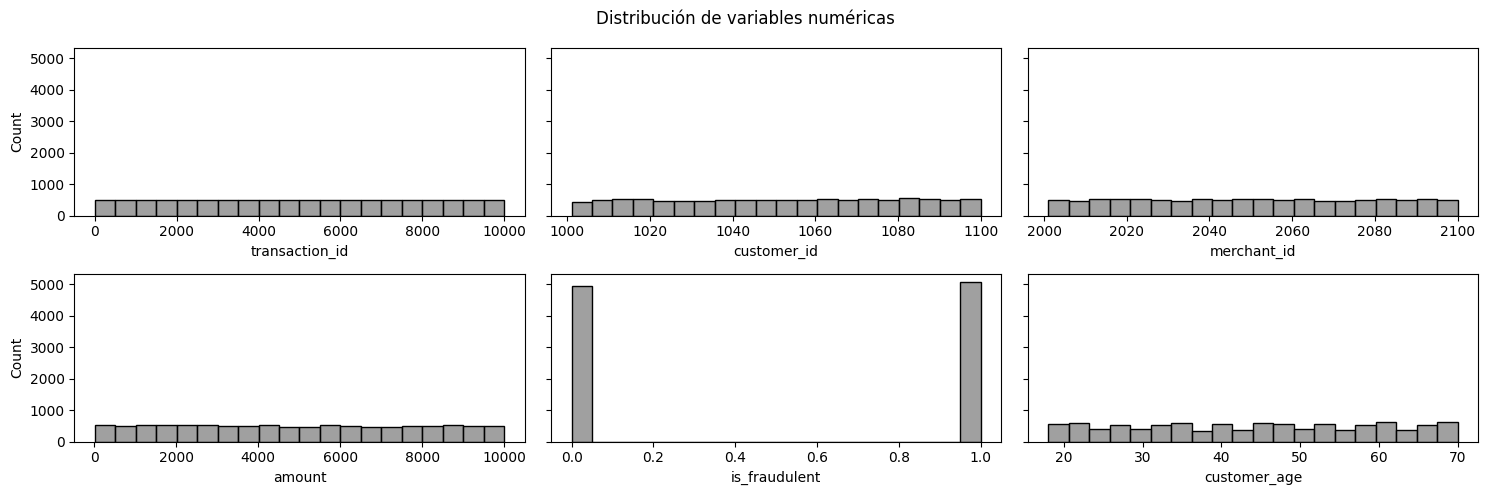

In [8]:
visualizador = sv.Visualizador(df)
visualizador.plot_numericas()

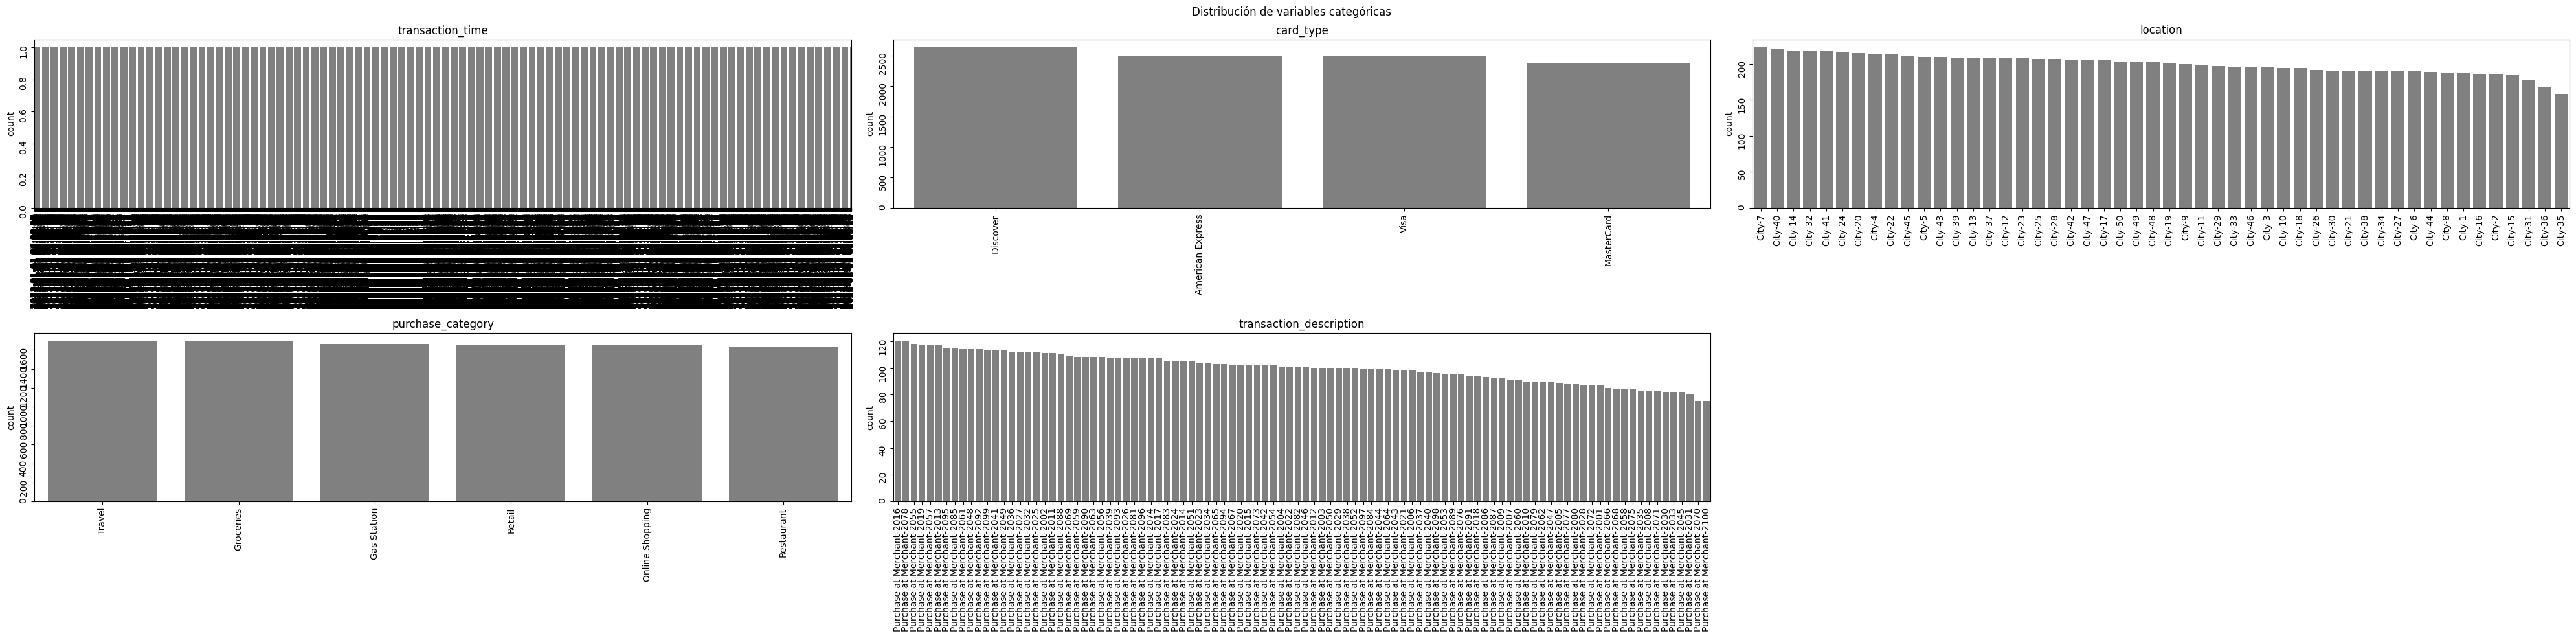

In [9]:
visualizador.plot_categoricas()

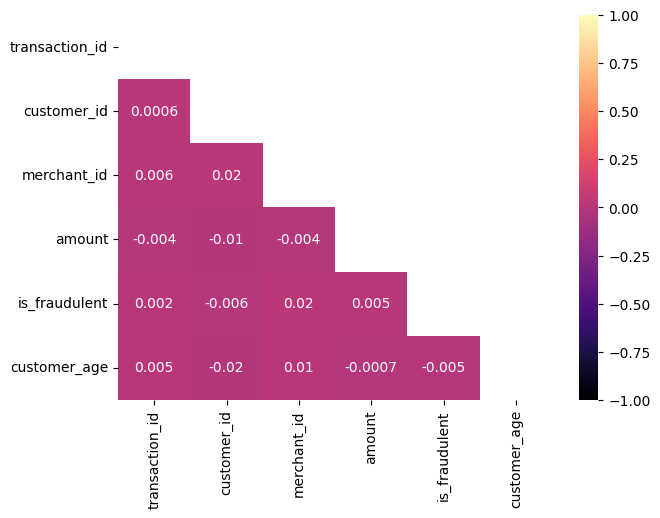

In [10]:
visualizador.correlacion()

- Tiene una distribución uniforme.
- No hay nulos, no hay duplicados.

In [11]:
def detectar_orden_cat(lista_categoricas, var_res):
    for categorica in lista_categoricas:
        print(f"Estamos evaluando la variable: {categorica.upper()}")
        df_cross_tab_gender = pd.crosstab(df[categorica], df[var_res])
        display(df_cross_tab_gender)

        chi2, p, dof, expected = chi2_contingency(df_cross_tab_gender)

        if p < 0.05:
            print(f"La variable categorica {categorica.upper()} si tiene orden\n")
        else:
            print(f"La variable categorica {categorica.upper()} no tiene orden\n")

detectar_orden_cat(df.select_dtypes(["object", "category"]), "is_fraudulent")

Estamos evaluando la variable: TRANSACTION_TIME


is_fraudulent,0,1
transaction_time,,
2023-01-01 00:00:00,1,0
2023-01-01 00:00:01,0,1
2023-01-01 00:00:02,0,1
2023-01-01 00:00:03,0,1
2023-01-01 00:00:04,0,1
...,...,...
2023-01-01 02:46:35,0,1
2023-01-01 02:46:36,1,0
2023-01-01 02:46:37,1,0


La variable categorica TRANSACTION_TIME no tiene orden

Estamos evaluando la variable: CARD_TYPE


is_fraudulent,0,1
card_type,,
American Express,1262,1232
Discover,1304,1329
MasterCard,1140,1243
Visa,1226,1264


La variable categorica CARD_TYPE no tiene orden

Estamos evaluando la variable: LOCATION


is_fraudulent,0,1
location,,
City-1,80,108
City-10,100,94
City-11,92,107
City-12,102,107
City-13,99,110
City-14,106,112
City-15,96,88
City-16,92,94
City-17,109,96


La variable categorica LOCATION no tiene orden

Estamos evaluando la variable: PURCHASE_CATEGORY


is_fraudulent,0,1
purchase_category,,
Gas Station,792,874
Groceries,796,896
Online Shopping,847,804
Restaurant,851,785
Retail,808,853
Travel,838,856


La variable categorica PURCHASE_CATEGORY si tiene orden

Estamos evaluando la variable: TRANSACTION_DESCRIPTION


is_fraudulent,0,1
transaction_description,,
Purchase at Merchant-2001,45,42
Purchase at Merchant-2002,59,52
Purchase at Merchant-2003,46,54
Purchase at Merchant-2004,49,52
Purchase at Merchant-2005,38,51
...,...,...
Purchase at Merchant-2096,59,48
Purchase at Merchant-2097,53,46
Purchase at Merchant-2098,44,52


La variable categorica TRANSACTION_DESCRIPTION no tiene orden



In [12]:
def detectar_orden_cat(lista_categoricas, var_res):
    lista_ordenas = []
    lista_desordenadas = []
    for categorica in lista_categoricas:
        print(f"Estamos evaluando la variable: {categorica.upper()}")
        df_cross_tab_gender = pd.crosstab(df[categorica], df[var_res])
        display(df_cross_tab_gender)

        chi2, p, dof, expected = chi2_contingency(df_cross_tab_gender)

        if p < 0.05:
            print(f"La variable categorica {categorica.upper()} si tiene orden\n")
            lista_ordenas.append(categorica)
        else:
            print(f"La variable categorica {categorica.upper()} no tiene orden\n")
            lista_desordenadas.append(categorica)

    return lista_ordenas, lista_desordenadas

In [13]:
lista_ordenadas, lista_desordenadas = detectar_orden_cat(df.select_dtypes(["object", "category"]), "is_fraudulent")
diccionario_encoding = {"target": lista_desordenadas, 
                        "onehot": lista_ordenadas}
print(lista_ordenadas)
print(lista_desordenadas)
# En caso de que queramos aplicar el método solo a una columna
encoding = se.Encoding(df, variable_respuesta="is_fraudulent", diccionario_encoding=diccionario_encoding)
df_oh = encoding.one_hot_encoding()
display(df_oh.head())
df_target = encoding.target_encoding()
df_target.head()

Estamos evaluando la variable: TRANSACTION_TIME


is_fraudulent,0,1
transaction_time,,
2023-01-01 00:00:00,1,0
2023-01-01 00:00:01,0,1
2023-01-01 00:00:02,0,1
2023-01-01 00:00:03,0,1
2023-01-01 00:00:04,0,1
...,...,...
2023-01-01 02:46:35,0,1
2023-01-01 02:46:36,1,0
2023-01-01 02:46:37,1,0


La variable categorica TRANSACTION_TIME no tiene orden

Estamos evaluando la variable: CARD_TYPE


is_fraudulent,0,1
card_type,,
American Express,1262,1232
Discover,1304,1329
MasterCard,1140,1243
Visa,1226,1264


La variable categorica CARD_TYPE no tiene orden

Estamos evaluando la variable: LOCATION


is_fraudulent,0,1
location,,
City-1,80,108
City-10,100,94
City-11,92,107
City-12,102,107
City-13,99,110
City-14,106,112
City-15,96,88
City-16,92,94
City-17,109,96


La variable categorica LOCATION no tiene orden

Estamos evaluando la variable: PURCHASE_CATEGORY


is_fraudulent,0,1
purchase_category,,
Gas Station,792,874
Groceries,796,896
Online Shopping,847,804
Restaurant,851,785
Retail,808,853
Travel,838,856


La variable categorica PURCHASE_CATEGORY si tiene orden

Estamos evaluando la variable: TRANSACTION_DESCRIPTION


is_fraudulent,0,1
transaction_description,,
Purchase at Merchant-2001,45,42
Purchase at Merchant-2002,59,52
Purchase at Merchant-2003,46,54
Purchase at Merchant-2004,49,52
Purchase at Merchant-2005,38,51
...,...,...
Purchase at Merchant-2096,59,48
Purchase at Merchant-2097,53,46
Purchase at Merchant-2098,44,52


La variable categorica TRANSACTION_DESCRIPTION no tiene orden

['purchase_category']
['transaction_time', 'card_type', 'location', 'transaction_description']


,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,43,Purchase at Merchant-2027,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,61,Purchase at Merchant-2053,0.0,0.0,1.0,0.0,0.0,0.0
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,57,Purchase at Merchant-2035,1.0,0.0,0.0,0.0,0.0,0.0
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,59,Purchase at Merchant-2037,0.0,0.0,0.0,0.0,0.0,1.0
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,36,Purchase at Merchant-2083,0.0,0.0,0.0,0.0,1.0,0.0


,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel
0,1,1082,2027,5758.59,0.440861,0,0.521611,0.497382,43,0.517856,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1015,2053,1901.56,0.570969,1,0.507631,0.529126,61,0.536825,0.0,0.0,1.0,0.0,0.0,0.0
2,3,1004,2035,1248.86,0.570969,1,0.521611,0.600000,57,0.506026,1.0,0.0,0.0,0.0,0.0,0.0
3,4,1095,2037,7619.05,0.570969,1,0.504747,0.600000,59,0.525765,0.0,0.0,0.0,0.0,0.0,1.0
4,5,1036,2083,1890.10,0.570969,1,0.521611,0.497382,36,0.523806,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Variable respuesta/objetivo is_fraudulent
# Si en el chi2 si hay diferencias One Hot, si no Target

In [15]:
# Outliers
outliers_uni = so.GestionOutliersUnivariados(df_target)
outliers_uni.detectar_outliers_z_score

<bound method GestionOutliersUnivariados.detectar_outliers_z_score of <src.soporte_outliers.GestionOutliersUnivariados object at 0x0000023AED1C57C0>>

In [16]:
from itertools import product

from tqdm import tqdm


outliers_multi = so.GestionOutliersMultivariados(df)
lista_neighbors = [20, 35, 50]
lista_contaminaciones =  [0.01, 0.05, 0.1]

combinaciones = list(product(lista_contaminaciones, lista_neighbors))
#df_prueba = df_target.copy()
for cont, vec in tqdm(combinaciones):
    df_temp = outliers_multi.detectar_outliers_lof(vec, cont)
    df_target = pd.concat([df_target, df_temp[df_temp.columns[-1]]], axis=1)

100%|██████████| 9/9 [00:00<00:00, 18.72it/s]


In [17]:
df_target.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel,outlier_lof_20_0.01,outlier_lof_35_0.01,outlier_lof_50_0.01,outlier_lof_20_0.05,outlier_lof_35_0.05,outlier_lof_50_0.05,outlier_lof_20_0.1,outlier_lof_35_0.1,outlier_lof_50_0.1
0,1,1082,2027,5758.59,0.440861,0,0.521611,0.497382,43,0.517856,1.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,1015,2053,1901.56,0.570969,1,0.507631,0.529126,61,0.536825,0.0,0.0,1.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1
2,3,1004,2035,1248.86,0.570969,1,0.521611,0.600000,57,0.506026,1.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,4,1095,2037,7619.05,0.570969,1,0.504747,0.600000,59,0.525765,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1,-1,-1,-1,-1,-1
4,5,1036,2083,1890.10,0.570969,1,0.521611,0.497382,36,0.523806,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,-1,-1,-1,-1,-1,-1


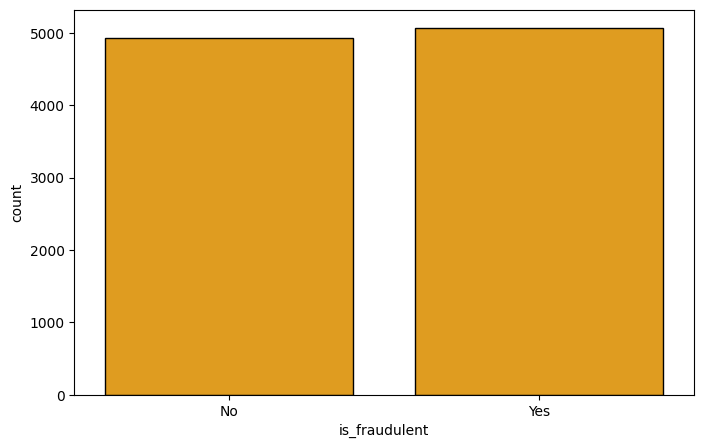

In [18]:
desbalanceo = sd.Desbalanceo(df_target, "is_fraudulent")
desbalanceo.visualizar_clase()

In [19]:
# Desbalanceo
df_balanceado_pandas = desbalanceo.balancear_clases_pandas("upsampling")
df_balanceado_pandas.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel,outlier_lof_20_0.01,outlier_lof_35_0.01,outlier_lof_50_0.01,outlier_lof_20_0.05,outlier_lof_35_0.05,outlier_lof_50_0.05,outlier_lof_20_0.1,outlier_lof_35_0.1,outlier_lof_50_0.1
1,2,1015,2053,1901.56,0.570969,1,0.507631,0.529126,61,0.536825,0.0,0.0,1.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1
2,3,1004,2035,1248.86,0.570969,1,0.521611,0.600000,57,0.506026,1.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,4,1095,2037,7619.05,0.570969,1,0.504747,0.600000,59,0.525765,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1,-1,-1,-1,-1,-1
4,5,1036,2083,1890.10,0.570969,1,0.521611,0.497382,36,0.523806,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,-1,-1,-1,-1,-1,-1
5,6,1032,2021,8487.68,0.570969,1,0.493986,0.574468,43,0.500003,1.0,0.0,0.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1


In [20]:
df_balanceado_imblearn = desbalanceo.balancear_clases_imblearn('RandomOverSampler')
df_balanceado_imblearn.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,card_type,location,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel,outlier_lof_20_0.01,outlier_lof_35_0.01,outlier_lof_50_0.01,outlier_lof_20_0.05,outlier_lof_35_0.05,outlier_lof_50_0.05,outlier_lof_20_0.1,outlier_lof_35_0.1,outlier_lof_50_0.1,is_fraudulent
0,1,1082,2027,5758.59,0.440861,0.521611,0.497382,43,0.517856,1.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
1,2,1015,2053,1901.56,0.570969,0.507631,0.529126,61,0.536825,0.0,0.0,1.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1,1
2,3,1004,2035,1248.86,0.570969,0.521611,0.600000,57,0.506026,1.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
3,4,1095,2037,7619.05,0.570969,0.504747,0.600000,59,0.525765,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1,-1,-1,-1,-1,-1,1
4,5,1036,2083,1890.10,0.570969,0.521611,0.497382,36,0.523806,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,-1,-1,-1,-1,-1,-1,1


In [21]:
df_balanceado_smote = desbalanceo.balancear_clases_smote()
df_balanceado_smote.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,card_type,location,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel,outlier_lof_20_0.01,outlier_lof_35_0.01,outlier_lof_50_0.01,outlier_lof_20_0.05,outlier_lof_35_0.05,outlier_lof_50_0.05,outlier_lof_20_0.1,outlier_lof_35_0.1,outlier_lof_50_0.1,is_fraudulent
0,1,1082,2027,5758.59,0.440861,0.521611,0.497382,43,0.517856,1.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
1,2,1015,2053,1901.56,0.570969,0.507631,0.529126,61,0.536825,0.0,0.0,1.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1,1
2,3,1004,2035,1248.86,0.570969,0.521611,0.600000,57,0.506026,1.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
3,4,1095,2037,7619.05,0.570969,0.504747,0.600000,59,0.525765,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1,-1,-1,-1,-1,-1,1
4,5,1036,2083,1890.10,0.570969,0.521611,0.497382,36,0.523806,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,-1,-1,-1,-1,-1,-1,1


In [22]:
df_balanceado_smote_tomek = desbalanceo.balancear_clases_smote_tomek()
df_balanceado_smote_tomek.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,card_type,location,customer_age,transaction_description,purchase_category_Gas Station,purchase_category_Groceries,purchase_category_Online Shopping,purchase_category_Restaurant,purchase_category_Retail,purchase_category_Travel,outlier_lof_20_0.01,outlier_lof_35_0.01,outlier_lof_50_0.01,outlier_lof_20_0.05,outlier_lof_35_0.05,outlier_lof_50_0.05,outlier_lof_20_0.1,outlier_lof_35_0.1,outlier_lof_50_0.1,is_fraudulent
0,1,1082,2027,5758.59,0.440861,0.521611,0.497382,43,0.517856,1.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
1,2,1015,2053,1901.56,0.570969,0.507631,0.529126,61,0.536825,0.0,0.0,1.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1,1
2,4,1095,2037,7619.05,0.570969,0.504747,0.600000,59,0.525765,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1,-1,-1,-1,-1,-1,1
3,5,1036,2083,1890.10,0.570969,0.521611,0.497382,36,0.523806,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,-1,-1,-1,-1,-1,-1,1
4,6,1032,2021,8487.68,0.570969,0.493986,0.574468,43,0.500003,1.0,0.0,0.0,0.0,0.0,0.0,-1,1,1,-1,-1,-1,-1,-1,-1,1


In [23]:
df_balanceado_smote_tomek.to_pickle("datos/financial_data_desbalanceado.pkl")